# 3.1 分類アルゴリズムの選択
いくつかの学習アルゴリズムの性能を比較し、特定の問題に最適なモデルを選択することが常に推奨される。  
特徴量やサンプルの個数、データベースでのノイズの量、そしてクラスの線形分離可能性に関して違いがあるかもしれない。  

機械学習のアルゴリズムのトレーニングは、以下の主要な5ステップから構成される。

1. 特徴量を選択する
1. 性能指標を選択する
1. 分類器と最適化アルゴリズムを選択する
1. モデルの性能を評価する
1. アルゴリズムを調整する

### 本章の目標
主にさまざまなアルゴリズムの主要な概念に着目する。  

### 本章ではない(のちの章)
特徴量の選択、性能指標、ハイパーパラメータなどについて  
scikit-learnライブラリは学習アルゴリズムだけでなく、データの前処理やモデルの調整・評価を行うための便利な関数を取り揃えている。  
この点については、第4章と第5章で詳しく説明する。

## 3.2.1 scikit-learnを使ったパーセプトロンのトレーニング
Irisデータセットを使う。  
特徴量を2つだけ使用する。  
150個のサンプルの「がく片の長さ」と「花びらの長さ」を特徴行列Xに代入し、対応する品種のクラスラベルをyに代入する。

In [1]:
from sklearn import datasets
import numpy as np
# Irisデータセットをロード
iris = datasets.load_iris()
# 3, 4列目の特徴量を抽出
X = iris.data[:, [2, 3]]
# クラスラベルを抽出
y = iris.target

次のように np.unique(y) を実行して iris.target に格納されているクラスラベルを取得すると、  
アヤメの花のクラス名であるIris-Setosa, Iris-Versicolor, Iris-Virginicaがすでに整数(0, 1, 2)として格納されていることがわかる。  
このようにクラスラベルの**文字列から整数への変換**は、多くの機械学習ライブラリで最適な性能を得るために推奨される方法である。

In [2]:
print("Class labels:", np.unique(y))

('Class labels:', array([0, 1, 2]))


In [3]:
from sklearn.cross_validation import train_test_split
# トレーニングデータとテストデータに分割
# 全体の30%をテストデータにする
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [8]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# トレーニングデータの平均と標準偏差を計算
sc.fit(X_train)
# 平均と標準偏差を用いて標準化
X_train_std = sc.transform(X_train)
X_test_sd = sc.transform(X_test)

In [9]:
from sklearn.linear_model import Perceptron
# エポック数40, 学習率0.1でパーセプトロンのインスタンスを生成
ppn = Perceptron(n_iter=40, eta0=0.1, random_state=0, shuffle=True)
# トレーニングデータをモデルに適合させる
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, eta0=0.1, fit_intercept=True,
      n_iter=40, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)

In [10]:
# テストデータで予測を実施
y_pred = ppn.predict(X_test_std)
# 誤分類のサンプルを表示
print("Missclassified samples: %d" % (y_test != y_pred).sum())

Missclassified samples: 4


In [11]:
from sklearn.metrics import accuracy_score
# 分類の正解率を表示
print("Accuracy: %.2f" % accuracy_score(y_test, y_pred))

Accuracy: 0.91


### 決定境界 plot_decision_regions関数 修正版

In [19]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%matplotlib inline

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    
    # マーカーとカラーマップの準備
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 決定領域のプロット
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # グリッドポイントの生成
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                                              np.arange(x2_min, x2_max, resolution))
    # 各特徴量を1次元配列に変換して予測を実行
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    # 予測結果を元のグリッドポイントのデータサイズに変換
    Z = Z.reshape(xx1.shape)
    # グリッドポイントの等高線のプロット
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    # 軸の範囲の設定
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # クラスごとにサンプルをプロット
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                           alpha=0.8, c=cmap(idx),
                           marker=markers[idx], label=cl)
    
    # テストサンプルを目立たせる(点で○を表示)
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='',
                           alpha=1.0, linewidths=1, marker='o',
                           s=55, label='test set')

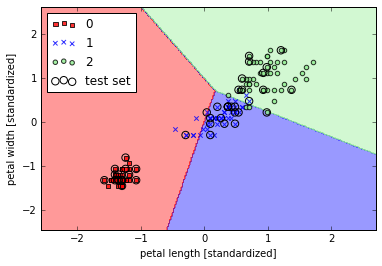

In [20]:
# トレーニングデータとテストデータの特徴量を行方向に結合
X_combined_std = np.vstack((X_train_std, X_test_std))
# トレーニングデータとテストデータのクラスラベルを結合
y_combined = np.hstack((y_train, y_test))
# 決定境界のプロット
plot_decision_regions(X=X_combined_std, y=y_combined, classifier=ppn, test_idx=range(105, 150))
# 軸のラベル設定
plt.xlabel("petal length [standardized]")
plt.ylabel("petal width [standardized]")
# 凡例の設定(左上に配置)
plt.legend(loc="upper left")
# グラフの表示
plt.show()

## 3.3 ロジスティック回帰を使ったクラスの確率のモデリング

- 回帰ではなく分類ですけどね
- 高い性能が発揮されるのは線形分離可能なクラスに対してのみ

### オッズ比
事象の起こりやすさ  
$$ \frac{p}{(1-p)} $$
対数オッズ  
$$ logit(p) = \log{\frac{p}{(1-p)}} $$

### シグモイド関数
logit関数の逆関数  
$$ \phi(z) = \frac{1}{1+e^{-z}} $$

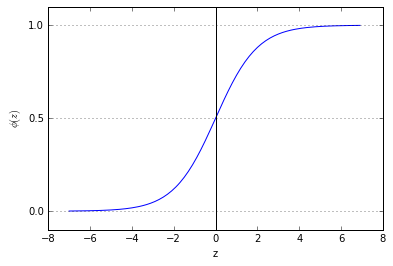

In [21]:
import matplotlib.pyplot as plt
import numpy as np
# シグモイド関数を定義
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

# 0.1間隔で-7以上7未満のデータを生成
z = np.arange(-7, 7, 0.1)
# 生成したデータでシグモイド関数を実行
phi_z = sigmoid(z)
# 元のデータとシグモイド関数の出力をプロット
plt.plot(z, phi_z)
# 垂直線を追加(z=0)
plt.axvline(0.0, color='k')
# y軸の上限/下限を設定
plt.ylim(-0.1, 1.1)
# 軸のラベルを設定
plt.xlabel('z')
plt.ylabel('$\phi (z)$')
# y軸の目盛を追加
plt.yticks([0.0, 0.5, 1.0])
# Axes クラスのオブジェクトの取得
ax = plt.gca()
# y軸の目盛に合わせて水平グリッド線を追加
ax.yaxis.grid(True)
# グラフの表示
plt.show()

### ロジスティック回帰のいいところ
予測されるクラスラベルに関心があるだけでなく、クラスの所属関係の確率を見積もることが特に役に立つ  

## 3.3.2 ロジスティック関数の重みの学習
ロジスティック回帰で最大化したい尤度を定義  
$$ L(w) = P(y|x; w) = \prod^n_{i=1} P(y^{(i)} | x^{(i)}; w) $$

対数尤度  
$$ l(w) = \log{L(w)} = \sum^n_{i=1}\biggl(y^{(i)}\log{(\phi(z^{(i)}) )} + (1 - y^{(i)})\log{(1 - \phi(z^{(i)}) )}\biggr) $$

コスト関数は負の対数尤度(Negative Log Likelihood)  
$$ J(w)= \sum^n_{i=1}\biggl(- y^{(i)}\log{(\phi(z^{(i)}) )} - (1 - y^{(i)})\log{(1 - \phi(z^{(i)}) )}\biggr) $$

## 3.3.3 scikit-learnによるロジスティック回帰モデルのトレーニング
scikit-learnには非常に最適化されたロジスティック回帰が実装されている  
実装はまたの機会とする(原書のgithubに"Bonus Notebooks"としてロジスティック回帰の実装がある)  

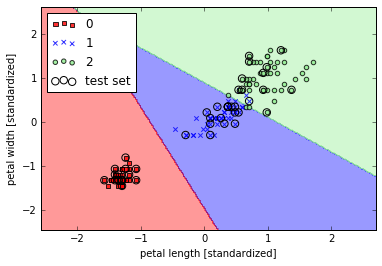

In [22]:
from sklearn.linear_model import LogisticRegression
# ロジスティック回帰のインスタンスを生成
lr = LogisticRegression(C=1000.0, random_state=0)
# トレーニングデータをモデルに適合させる
lr.fit(X_train_std, y_train)
# 決定境界をプロット
plot_decision_regions(X_combined_std, y_combined, classifier=lr, test_idx=range(105,150))
# 軸のラベルを設定
plt.xlabel("petal length [standardized]")
plt.ylabel("petal width [standardized]")
# 凡例を設定(左上に配置)
plt.legend(loc="upper left")
# グラフを表示
plt.show()

In [23]:
# predict_probaメソッドを使ってサンプルの所属関係の確率を予測
lr.predict_proba(X_test_std[0, :])

/Users/music/.pyenv/versions/2.7.10/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[  2.05743774e-11,   6.31620264e-02,   9.36837974e-01]])

## 3.3.4 正則化による過学習への対処

- 過学習が発生してるモデル = 「バリアンスが高い」
- モデルの複雑さが十分でなく性能が低い　= 「バイアスが高い」

L2正則化  
$$\frac{\lambda}{2}\|w\|^2$$

scikit-learnのLogisticRegressionクラスに実装されているパラメータCは、サポートベクトルマシンの慣例に由来する  
Cは正則化パラメータの逆数  
$$ C = \frac{1}{\lambda} $$

コスト関数に正則化の項を追加するだけでよい

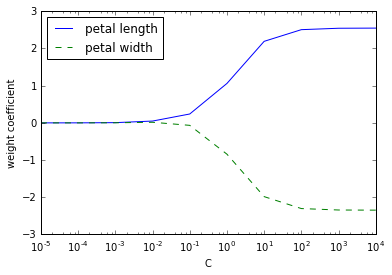

In [24]:
# からのリストを生成(重み係数、逆正則化パラメータ)
weights, params = [], []
# 10個の逆正規化パラメータに対応するロジスティック回帰モデルをそれぞれ処理
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10**c, random_state=0)
    lr.fit(X_train_std, y_train)
    # 重み係数を格納
    weights.append(lr.coef_[1])
    # 逆正規化パラメータを格納
    params.append(10**c)


# 重み係数をNumPy配列に変換
weights = np.array(weights)
# 横軸に逆正規化パラメータ、縦軸に重み係数をプロット
plt.plot(params, weights[:, 0], label="petal length")
plt.plot(params, weights[:, 1], linestyle='--', label="petal width")
plt.ylabel("weight coefficient")
plt.xlabel("C")
plt.legend(loc="upper left")
# 横軸を対数スケールに設定
plt.xscale('log')
plt.show()

# 3.4 サポートベクトルマシンによる最大マージン分類

- パーセプトロンの拡張版
- パーセプトロンは誤分類率を最小化
- SVMはマージンを最大化

### マージン
超平面(決定境界)と、この超平面に最も近いトレーニングサンプルとの間の距離  
超平面に最も近いトレーニングサンプルは**サポートベクトル**と呼ばれる。


## 3.4.1 最大マージンの直感的理解

$$ w_0 + w^Tx_{pos} = 1 $$
$$ w_0 + w^Tx_{neg} = -1 $$

2つの線形方程式を引き算すると  
$$ w^T(x_{pos} - x_{neg}) = 2 $$

ベクトルの長さの定義  
$$ \|w\| = \sqrt{\sum^m_{j=1} w^2_j} $$

$$ \frac{w^T(x_{pos} - x_{neg})}{\|w\|} = \frac{2}{\|w\|} $$

左辺は、正の超平面と負の超平面の距離、つまり最大化したいマージンである  
実際には逆数をとって2乗した$\frac{1}{2}\|w\|^2$を最小化するほうが簡単  
二次計画法により解くことができる

In [25]:
from sklearn.svm import SVC
# 線形SVMのインスタンスを生成
svm = SVC(kernel='linear', C=1.0, random_state=0)

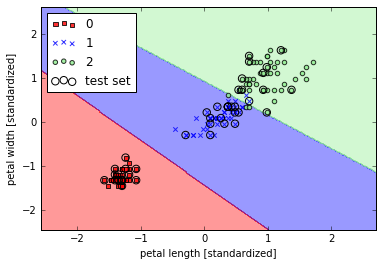

In [26]:
# 線形SVMのモデルにトレーニングデータを適合させる
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svm, test_idx=range(105, 150))
plt.xlabel("petal length [standardized]")
plt.ylabel("petal width [standardized]")
plt.legend(loc="upper left")
plt.show()

# 3.5 カーネルSVMを使った非線形問題の求解

非線形分類の問題を解くために「カーネル化」  

- XORゲート形式の単純なデータセットを作成
- 100個のサンプルにクラスラベル1を割り当て、その他の100個に-1

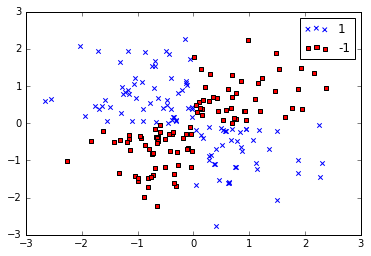

In [27]:
# 乱数種を指定
np.random.seed(0)
#標準正規分布に従う乱数で200行2列の行列を生成
X_xor = np.random.randn(200, 2)
# 2つの引数に対して排他的論理和を実行
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
# 排他的論理和の値が真の場合は1, 偽の場合は-1を割り当てる
y_xor = np.where(y_xor, 1, -1)
# ラベル1を青のxでプロット
plt.scatter(X_xor[y_xor==1, 0], X_xor[y_xor==1, 1],
                    c='b', marker='x', label='1')
# ラベル-1を赤の四角でプロット
plt.scatter(X_xor[y_xor==-1, 0], X_xor[y_xor==-1, 1],
                    c='r', marker='s', label='-1')
# 軸の範囲を設定
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc="best")
plt.show()

カーネル手法の基本的な発想は射影関数$\phi (\cdot)$を使ってそれらの組み合わせを高次元空間へ射影し、線形分離できるようにする  
$$ \phi(x_1, x_2) = (z_1, z_2, z_3) = (x_1, x_2, x_1^2 + x_2^2) $$

### カーネルトリック
ベクトルのドット積 ${x^{(i)}}^Tx^{(j)}$ を$\phi(x^{(i)})^T\phi(x^{(i)})$に置換する  

カーネル関数  
$$ k(x^{(i)}, x^{(j)}) =  \phi(x^{(i)})^T\phi(x^{(i)})$$

よく使われる動径基底関数カーネル(Radial Basis Function Kernel)  
$$ k(x^{(i)}, x^{(j)}) = \exp{\biggl(-\frac{\|x^{(i)} - x^{(j)}\|^2}{2\sigma^2}\biggr)} $$
簡略化  
$$ k(x^{(i)}, x^{(j)}) = \exp{\biggl(-\gamma\|x^{(i)} - x^{(j)}\|^2\biggr)} $$

ここで$\gamma = \frac{1}{2\sigma^2}$は最適化対象のハイパーパラメータ  

- 「カーネル」は２つの関数の「類似性」を表す関数
- マイナス記号は距離の指標を反転させて類似度にするため
- 指数関数のべき乗部分が0から無限大を値をとることにより、得られる類似度は1(全く同じ)から0(全く異なる)の範囲に収まる

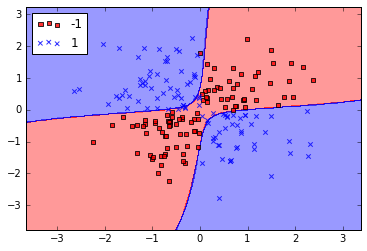

In [28]:
# RBFカーネルによるSVMのインスタンスを生成
svm = SVC(kernel='rbf', random_state=0, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc="upper left")
plt.show()

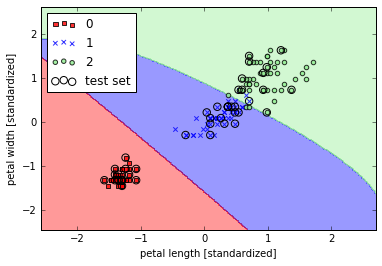

In [29]:
# RBFカーネルによるSVMのインスタンスを生成(2つのパラメータ変更)
svm = SVC(kernel='rbf', random_state=0, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svm,
                                         test_idx=range(105, 150))
plt.xlabel("petal length [standardized]")
plt.ylabel("petal width [standardized]")
plt.legend(loc="upper left")
plt.show()

$\gamma$パラメータの値を大きくし、決定境界にどのような影響が及ぶか確認

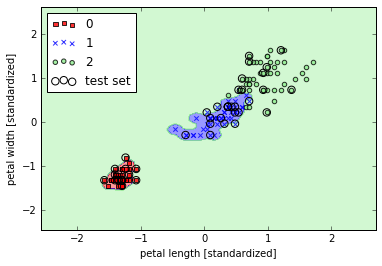

In [30]:
# RBFカーネルによるSVMのインスタンスを生成(2つのパラメータ変更)
svm = SVC(kernel='rbf', random_state=0, gamma=100.0, C=1.0)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svm,
                                         test_idx=range(105, 150))
plt.xlabel("petal length [standardized]")
plt.ylabel("petal width [standardized]")
plt.legend(loc="upper left")
plt.show()

$\gamma$パラメータに比較的大きな値を使用すると、クラス0とクラス1のまわりの決定境界がかなり複雑になることがわかる。  

適合度は高いが、未知のデータで高い汎化誤差が生じる  
過学習を抑制するためにも$\gamma$の最適化が重要な役割を果たすことを示している

# 3.6 決定木学習
意味解釈可能性：得られた結果の意味を解釈しやすいかどうか  
に配慮する場合に魅力的なモデル

$$ IG(D_p,f) = I(D_p) - \sum^m_{j=1} \frac{N_j}{N_p} I (D_j) $$

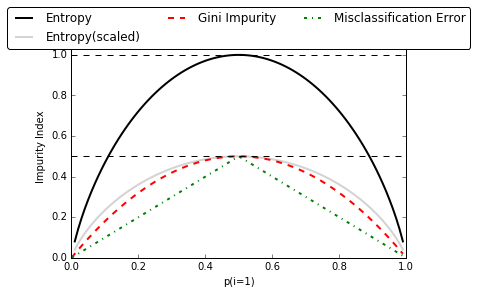

In [31]:
import matplotlib.pyplot as plt
import numpy as np
# ジニ不純度の関数を定義
def gini(p):
    return (p)*(1 - (p)) + (1 - p)*(1 - (1 - p))

# エントロピーの関数を定義
def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))

# 分類誤差の関数を定義
def error(p):
    return 1 - np.max([p, 1 - p])

# 確率を表す配列を生成(0~0.99まで0.01刻み)
x = np.arange(0.0, 1.0, 0.01)
# 配列の値をもとにエントロピー、分類誤差を計算
ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(i) for i in x]
# 図の作成を開始
fig = plt.figure()
ax = plt.subplot(111)
# エントロピー(2種)、ジニ不純度、分類誤差のそれぞれをループ処理
for i , lab, ls, c, in zip([ent, sc_ent, gini(x), err],
                                    ['Entropy', 'Entropy(scaled)',
                                      'Gini Impurity', 'Misclassification Error'],
                                      ['-', '-', '--', '-.'],
                                      ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)
# 凡例の設定
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15),
                 ncol=3, fancybox=True, shadow=False)
# 2本の水平の破線を引く
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
# 横軸の上限/下限を設定
plt.ylim([0, 1.1])
plt.xlabel("p(i=1)")
plt.ylabel("Impurity Index")
plt.show()

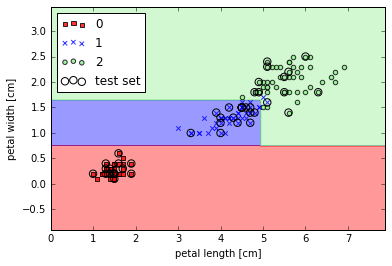

In [32]:
from sklearn.tree import DecisionTreeClassifier
# エントロピーを指標とする決定木のインスタンスを生成
tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
# 決定木のモデルにトレーニングデータを適合させる
tree.fit(X_train, y_train)
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, classifier=tree,
                                         test_idx=range(105, 150))
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc="upper left")
plt.show()

In [36]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", feature_names=["petal length", "petal width"])

## 3.6.3 ランダムフォレスト

### ランダムフォレスト

- 分類性能が高い
- スケーラビリティに優れる
- 使いやすい
- 直感的には決定木のアンサンブル

### ステップ

1. 大きさnのランダムな「ブートストラップ」標本を復元抽出(重複を許す抽出)
1. ブートストラップ標本から決定木を成長させる
    - d個の特徴量をランダムに非復元抽出する
    - 情報利得を最大化することにより、目的関数に従って最適な分割となる特徴量を使ってノードを分割
1. ステップ1~2をk回繰り返す
1. 決定木ごとの予測をまとめて、「多数決」に基づいてクラスラベルを割り当てる。多数決については第7章で説明

配慮すべきパラメータは決定木の個数k  
決定木の個数が多いほど性能がよくなるが計算コストがかかる  

ブートストラップ標本nと特徴量の個数dは最適化が可能(第5章)  

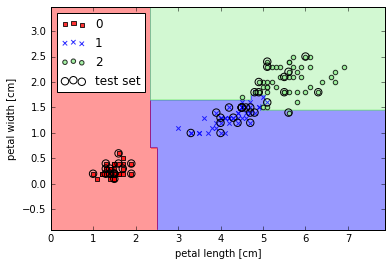

In [37]:
from sklearn.ensemble import RandomForestClassifier
# エントロピーを指標とするランダムフォレストのインスタンスを生成
forest = RandomForestClassifier(criterion="entropy", n_estimators=10, random_state=1, n_jobs=2)
# ランダムフォレストのモデルにトレーニングデータを適合させる
forest.fit(X_train, y_train)
plot_decision_regions(X_combined, y_combined, classifier=forest, test_idx=range(105, 150))
plt.xlabel("petal length [cm]")
plt.ylabel("petal width [cm]")
plt.legend(loc="upper left")
plt.show()

# 3.7 k近傍法 : 怠惰学習アルゴリズム
「怠惰」と呼ばれるのは、トレーニングデータセットから識別関数を学習せず、トレーニングデータセットを暗記するため  

### KNNのステップ

1. kの値と距離指標を選択
1. 分類したいサンプルからk個の最近傍のデータ点を見つけ出す
1. 多数決によりクラスラベルを割り当てる

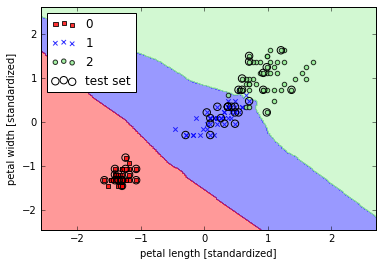

In [38]:
from sklearn.neighbors import KNeighborsClassifier
# k近傍法のインスタンスを生成
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
# k近傍法のモデルにトレーニングデータを適合させる
knn.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=knn, test_idx=range(105, 150))
plt.xlabel("petal length [standardized]")
plt.ylabel("petal width [standardized]")
plt.legend(loc="upper left")
plt.show()